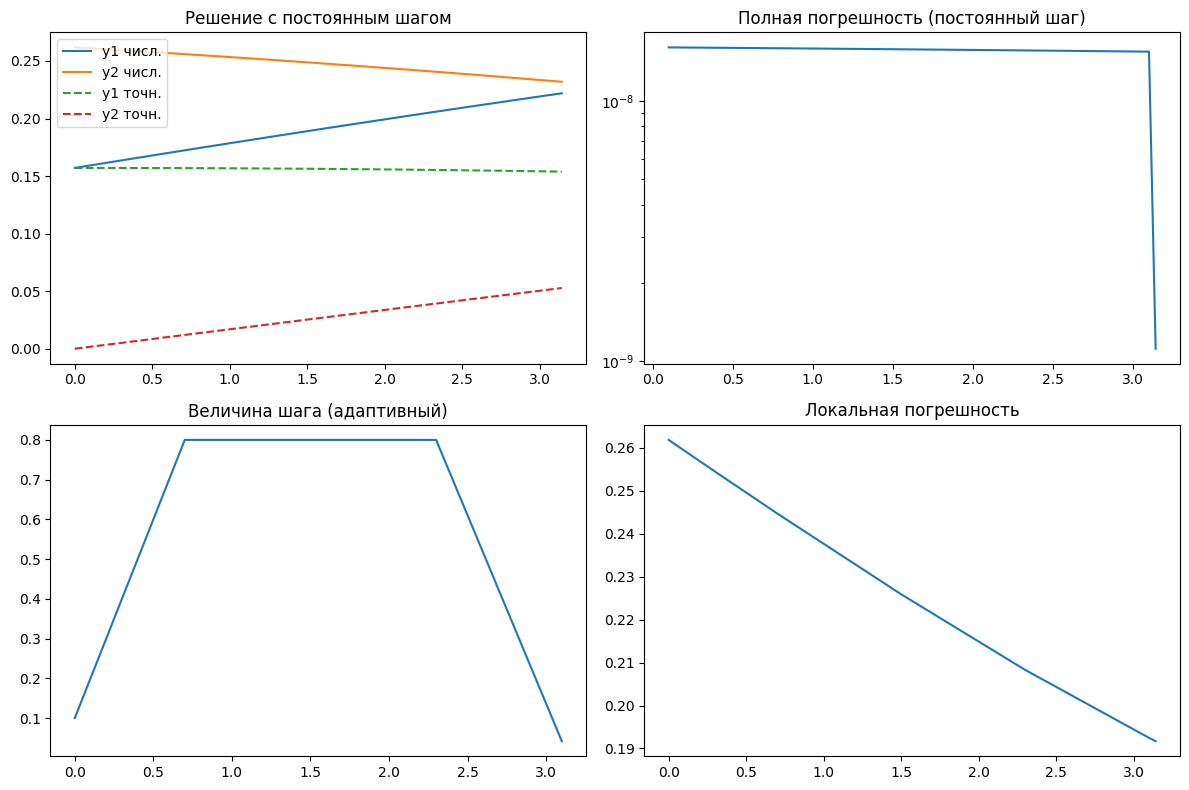

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры варианта (пример для варианта 10)
xi = 1/12
A = 1/12
B = 1/20
epsilon = 1e-4
rho_max = 1e-5

# Точное решение системы (для проверки)
def exact_solution(x):
    omega = np.sqrt(A*B)
    y1 = B * np.pi * np.cos(omega * x)
    y2 = A * np.pi * np.sin(omega * x)
    return np.array([y1, y2])

# Правая часть системы ОДУ
def f(x, y):
    return np.array([A * y[1], -B * y[0]])

# Построение коэффициентов для 2-этапного ЯМРК 2 порядка
def build_rk2_coeffs(xi):
    b2 = 1 / (2 * xi)
    a21 = xi
    b1 = 1 - b2
    return a21, b1, b2

a21, b1, b2 = build_rk2_coeffs(xi)

# Реализация метода Рунге-Кутты 2 порядка
def rk2_step(f, x, y, h):
    k1 = h * f(x, y)
    k2 = h * f(x + a21*h, y + a21*k1)
    y_new = y + b1*k1 + b2*k2
    return y_new

# Метод Рунге для оценки полной погрешности
def runge_estimate(f, x, y, h, order):
    # Шаг h
    y_h = rk2_step(f, x, y, h)
    # Два шага h/2
    h_half = h / 2
    y_half1 = rk2_step(f, x, y, h_half)
    y_half2 = rk2_step(f, x + h_half, y_half1, h_half)
    # Оценка погрешности
    error = (y_half2 - y_h) / (1 - 2**(-order))
    return y_half2, error

# Алгоритм выбора начального шага (упрощенный)
def initial_step(f, x0, y0, epsilon):
    h = 0.1  # Начальное предположение
    for _ in range(10):
        y1 = rk2_step(f, x0, y0, h)
        y2 = rk2_step(f, x0, y0, h/2)
        y2 = rk2_step(f, x0 + h/2, y2, h/2)
        error = np.linalg.norm(y2 - y1) / (1 - 2**(-2))
        if error < epsilon:
            break
        h /= 2
    return h

# Решение с постоянным шагом
def solve_constant_step(f, x0, y0, x_end, h, epsilon):
    x = [x0]
    y = [y0]
    errors = []
    
    while x[-1] < x_end:
        if x[-1] + h > x_end:
            h = x_end - x[-1]
        
        # Шаг с оценкой погрешности
        y_new, error = runge_estimate(f, x[-1], y[-1], h, 2)
        
        # Сохраняем результат
        x.append(x[-1] + h)
        y.append(y_new)
        errors.append(np.linalg.norm(error))
    
    return np.array(x), np.array(y), np.array(errors)

# Решение с автоматическим выбором шага
def solve_adaptive_step(f, x0, y0, x_end, h_init, rho_max, epsilon):
    x = [x0]
    y = [y0]
    h = h_init
    steps = []
    
    while x[-1] < x_end:
        if x[-1] + h > x_end:
            h = x_end - x[-1]
        
        # Вычисляем два приближения
        y_h = rk2_step(f, x[-1], y[-1], h)
        y_half1 = rk2_step(f, x[-1], y[-1], h/2)
        y_half2 = rk2_step(f, x[-1] + h/2, y_half1, h/2)
        
        # Оценка локальной погрешности
        error = np.linalg.norm(y_half2 - y_h) / (1 - 2**(-2))
        
        # Контроль шага
        if error > rho_max:
            h /= 2
        else:
            x.append(x[-1] + h)
            y.append(y_half2)
            steps.append(h)
            if error < rho_max / 4:
                h *= 2
                
    return np.array(x), np.array(y), np.array(steps)

# Часть 1.2: Решение с постоянным шагом
x0 = 0
y0 = np.array([B * np.pi, A * np.pi])
x_end = np.pi
h_init = initial_step(f, x0, y0, epsilon)
x_const, y_const, errors_const = solve_constant_step(f, x0, y0, x_end, h_init, epsilon)

# Часть 2.1: Решение с автоматическим шагом
x_adapt, y_adapt, steps_adapt = solve_adaptive_step(f, x0, y0, x_end, h_init, rho_max, epsilon)

# Визуализация результатов
plt.figure(figsize=(12, 8))

# График решения
plt.subplot(2, 2, 1)
plt.plot(x_const, y_const[:, 0], label='y1 числ.')
plt.plot(x_const, y_const[:, 1], label='y2 числ.')
x_exact = np.linspace(0, np.pi, 100)
y_exact = exact_solution(x_exact)
plt.plot(x_exact, y_exact[0], '--', label='y1 точн.')
plt.plot(x_exact, y_exact[1], '--', label='y2 точн.')
plt.title('Решение с постоянным шагом')
plt.legend()

# График погрешности
plt.subplot(2, 2, 2)
plt.semilogy(x_const[1:], errors_const)
plt.title('Полная погрешность (постоянный шаг)')

# График шагов
plt.subplot(2, 2, 3)
plt.plot(x_adapt[:-1], steps_adapt)
plt.title('Величина шага (адаптивный)')

# Отношение погрешностей
plt.subplot(2, 2, 4)
local_errors = [np.linalg.norm(y_adapt[i] - exact_solution(x_adapt[i])) for i in range(len(x_adapt))]
plt.plot(x_adapt, local_errors)
plt.title('Локальная погрешность')
plt.tight_layout()
plt.show()

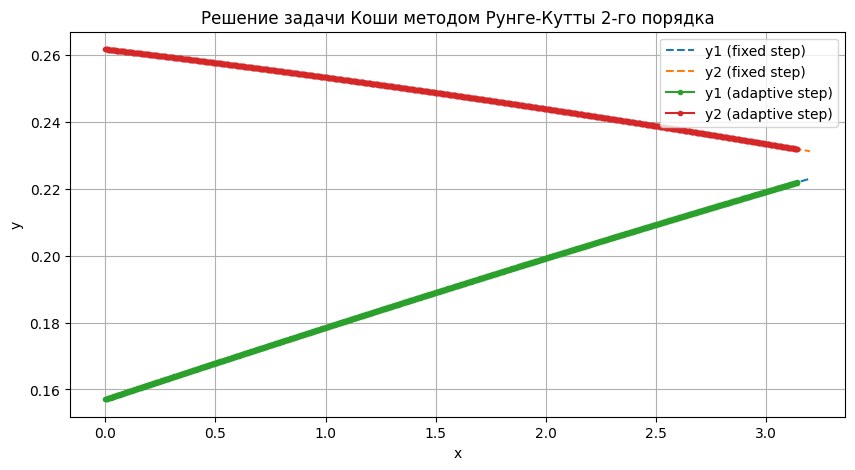

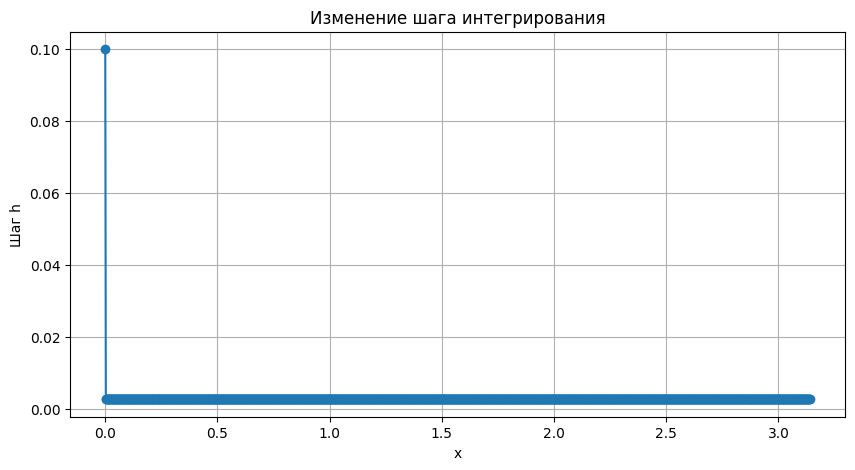

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Функция правых частей системы
A, B = 1/12, 1/20  # Подставьте ваши значения

def f(x, y):
    y1, y2 = y
    return np.array([A * y2, -B * y1])

# Метод Рунге-Кутты 2-го порядка с постоянным шагом
def runge_kutta_2_fixed_step(f, y0, x0, x_end, h):
    x_values = np.arange(x0, x_end + h, h)
    y_values = np.zeros((len(x_values), len(y0)))
    y_values[0] = y0
    
    for i in range(1, len(x_values)):
        x = x_values[i-1]
        y = y_values[i-1]
        k1 = h * f(x, y)
        k2 = h * f(x + h, y + k1)
        y_values[i] = y + 0.5 * (k1 + k2)
    
    return x_values, y_values

# Метод Рунге-Кутты 2-го порядка с автоматическим выбором шага
def runge_kutta_2_adaptive_step(f, y0, x0, x_end, h_init, tol):
    x_values, y_values, h_values = [x0], [y0], [h_init]
    x, y, h = x0, y0, h_init
    
    while x < x_end:
        k1 = h * f(x, y)
        k2 = h * f(x + h, y + k1)
        y1 = y + 0.5 * (k1 + k2)
        
        h_half = h / 2
        k1_half = h_half * f(x, y)
        k2_half = h_half * f(x + h_half, y + k1_half)
        y2_half = y + 0.5 * (k1_half + k2_half)
        
        error = np.linalg.norm(y1 - y2_half) / 3
        if error < tol:
            x += h
            y = y1
            x_values.append(x)
            y_values.append(y)
            h_values.append(h)
        h = h * min(2, max(0.5, (tol / error) ** 0.5))
    
    return np.array(x_values), np.array(y_values), np.array(h_values)

# Параметры задачи
x0, x_end = 0, np.pi
y0 = np.array([B * np.pi, A * np.pi])
h_init, tol = 0.1, 1e-5

# Запуск методов
x_fixed, y_fixed = runge_kutta_2_fixed_step(f, y0, x0, x_end, h_init)
x_adaptive, y_adaptive, h_values = runge_kutta_2_adaptive_step(f, y0, x0, x_end, h_init, tol)

# Графики решений
plt.figure(figsize=(10, 5))
plt.plot(x_fixed, y_fixed[:, 0], label='y1 (fixed step)', linestyle='dashed')
plt.plot(x_fixed, y_fixed[:, 1], label='y2 (fixed step)', linestyle='dashed')
plt.plot(x_adaptive, y_adaptive[:, 0], label='y1 (adaptive step)', marker='o', markersize=3)
plt.plot(x_adaptive, y_adaptive[:, 1], label='y2 (adaptive step)', marker='o', markersize=3)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Решение задачи Коши методом Рунге-Кутты 2-го порядка')
plt.grid()
plt.show()

# График изменения шага
plt.figure(figsize=(10, 5))
plt.plot(x_adaptive[:-1], h_values[:-1], marker='o', linestyle='-')
plt.xlabel('x')
plt.ylabel('Шаг h')
plt.title('Изменение шага интегрирования')
plt.grid()
plt.show()
